In [ ]:
# !pip install ISR -U
# !pip install 'h5py==2.10.0' --force-reinstall
# # restart after installation

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from imageio import imread
import shutil
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch import nn, optim, device
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary

from ISR.models import RDN

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !pip install kaggle
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d ikarus777/best-artworks-of-all-time 

In [7]:
# !mkdir artworks
# !unzip -q '/content/best-artworks-of-all-time.zip' -d '/content/artworks/'

In [8]:
df = pd.read_csv('/content/artworks/artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [9]:
# Most popular genres
df.groupby('genre')['paintings'].sum().sort_values(ascending=False)

genre
Impressionism                              1370
Post-Impressionism                         1048
Northern Renaissance                        680
Baroque                                     586
Cubism                                      439
Romanticism                                 388
Symbolism,Post-Impressionism                311
Primitivism                                 309
High Renaissance                            301
Impressionism,Post-Impressionism            277
High Renaissance,Mannerism                  255
Surrealism                                  241
Surrealism,Impressionism                    194
Expressionism                               193
Expressionism,Abstractionism,Surrealism     188
Pop Art                                     181
Symbolism                                   171
Early Renaissance                           164
Suprematism                                 126
Primitivism,Surrealism                      120
Proto Renaissance                 

In [10]:
# Saving artists with genres 'Impressionism' and 'Post-Impressionism'
artist = df[(df['genre'] == 'Impressionism') | (df['genre'] == 'Post-Impressionism')]['name'].tolist()

In [11]:
artistlist = []
for i in artist:
  artistlist.append(i.replace(' ', '_'))
artistlist

['Claude_Monet',
 'Vincent_van_Gogh',
 'Pierre-Auguste_Renoir',
 'Alfred_Sisley',
 'Edgar_Degas',
 'Henri_de_Toulouse-Lautrec',
 'Paul_Cezanne',
 'Georges_Seurat']

In [12]:
!mkdir /content/Dataset_art

In [13]:
# Copying their works to a new directory
for i in artistlist:
  os.chdir('/content/artworks/images/images/'+i)
  dst_dir = '/content/Dataset_art/'
  for f in os.listdir():
    shutil.copy(f, dst_dir)

In [14]:
# Checking for greyscale images (with only one channel)
os.chdir('/content/Dataset_art/')
for filename in os.listdir():
  image = imread(filename)
  if(len(image.shape)<3):
        print(filename)

Alfred_Sisley_199.jpg


In [15]:
# Deleting them
!rm /content/Dataset_art/Alfred_Sisley_199.jpg

In [16]:
# Preparing our images for dataloader
class Arts(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.total_imgs)
        
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image

In [17]:
image_size = 64 # input shape of images 64x64
batch_size = 64
latent_size = 100 # input shape for generator
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean and std to normalize the image in the range [-1, 1]

In [18]:
# to resize all images to 64x64 and normalize pixels values in the range [-1, 1]
transform = tt.Compose([tt.Resize((image_size, image_size)),
                        tt.ToTensor(), # This makes it into [0, 1]
                        tt.Normalize(*stats)]) # This makes it into [-1, 1]

In [19]:
# Function to get images back in original range [0, 1]
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [20]:
# to show all images from batch
def show_images(batch, number_to_show=batch_size):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(batch.detach()[:number_to_show]), nrow=8).permute(1, 2, 0))

In [21]:
arts = Arts('/content/Dataset_art', transform)

In [22]:
# creating dataloader
train_dl = DataLoader(arts, batch_size, shuffle=True, pin_memory=True)

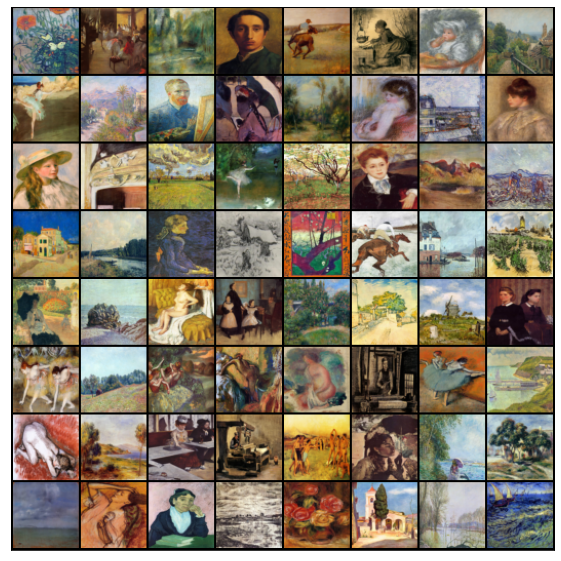

In [23]:
# Original images
images = next(iter(train_dl)) # one batch
show_images(images, batch_size)

In [24]:
cd '/content/'

/content


In [33]:
# Folder to save generated images
os.makedirs('generated', exist_ok=True)

# Folder to save D weights
os.makedirs('generated/saved_d', exist_ok=True)

# Folder to save G weights
os.makedirs('generated/saved_g', exist_ok=True)

# Function to save and show the samples produced during epochs
def save_samples(images, index):
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(images), os.path.join('generated', fake_fname), nrow=8)
    print('Saving', fake_fname)
    if index == 1 or index % 25 == 0:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title(f'Generated images on epoch {index}')
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images.cpu().detach()), nrow=8).permute(1, 2, 0))

In [35]:
# custom weights initialization called on G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [36]:
# set class of discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            # in: 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid())

    def forward(self, x):
        output = self.layer(x)
        return output

    
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
summary(discriminator, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Flatten-13                    [-1, 1]               0
          Sigmoid-14                   

In [37]:
# set class of generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer =  nn.Sequential(
            # in: latent_size x 1 x 1

            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())
            # out: 3 x 64 x 64

            
    def forward(self, x):
        output = self.layer(x)
        return output

    
generator = Generator().to(device)
generator.apply(weights_init)
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [38]:
# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)

# Losses & scores to plot later
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

# Create optimizers
opt_d = optim.Adam(discriminator.parameters(), lr= 0.0005, betas=(0.5, 0.999))
opt_g = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))

# Loss function
loss_fn = nn.BCELoss()

In [39]:
# function to check if gradients are exploding
def check_grads(model, model_name, value):
    grads = []
    for p in model.parameters():
        grads.append(p.grad.data.norm(2).item())

    grads = np.array(grads)
    if grads.mean() > value:
        print(f"WARNING! gradients mean is over {value}, model: {model_name}")
        print('max:', grads.max())
    if grads.max() > value:
        print(f"WARNING! gradients max is over {value}, model: {model_name}")
        print('max:', grads.max())

In [40]:
# function to plot losses and accuracy
def plot_history():
    plt.style.use('ggplot')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
    ax1.plot(losses_g, label='G loss')
    ax1.plot(losses_d, label='D loss')
    ax1.set_title(f'Losses of G and D')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss, BCE')
    ax1.legend()
    ax2.plot(real_scores, label='on real images')
    ax2.plot(fake_scores, label='on fake(generated) images')
    ax2.set_title(f'D Predictions accuracy on real and fake images')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

In [41]:
def training_loop(epochs, start_idx=1):
    torch.cuda.empty_cache()
    for epoch in range(epochs):
        epoch_losses_g = 0
        epoch_losses_d = 0
        epoch_real_scores = []
        epoch_fake_scores = []
        for real_images in tqdm(train_dl):
            real_images = real_images.to(device)
            
            """
            Discriminator training
            """

            # Clear D gradients
            opt_d.zero_grad()

            # Pass real images through D
            real_preds = discriminator(real_images).to(device) # getting the predictions for real images
            real_targets = torch.ones(real_images.size(0), 1).to(device) # for real images setting targets as 1
            D_real_loss = loss_fn(real_preds, real_targets) # getting the loss for real images
            
            # Save mean real score of D for this batch
            epoch_real_scores.append(real_preds.mean().item()) 
            
            # Calculate gradients for D
            D_real_loss.backward()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1).to(device) # random noise for input image
            fake_images = generator(latent).to(device)  # generating the fake images

            # Pass fake images through D
            fake_preds = discriminator(fake_images.detach()).to(device)  # getting the predictions for fake images
            fake_targets = torch.zeros(fake_images.size(0), 1).to(device) # for fake images setting targets as 0
            D_fake_loss = loss_fn(fake_preds, fake_targets)  # getting the loss for fake images
            
            # Save mean fake score of D for this batch
            epoch_fake_scores.append(fake_preds.mean().item()) 
 
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            D_fake_loss.backward()

            # Compute loss of D as sum over the fake and the real images
            D_loss = D_real_loss + D_fake_loss

            # Save loss of D for this batch
            epoch_losses_d += D_loss.item()
            
            
            # Checking norm of gradients 
#             check_grads(discriminator, "Discriminator", 1)

            # Clip gradients to avoid 'exploding gradients' problem 
#             nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1, norm_type=2)

            # Update D
            opt_d.step()

    
            """
            Generator training
            """
        
            # Clear G gradients
            opt_g.zero_grad()

            # Since we just updated D, perform another forward pass of fake images through D
            fake_preds = discriminator(fake_images).to(device)
            fake_targets = torch.ones(fake_images.size(0), 1).to(device) # fake labels are real for generator cost
            G_loss = loss_fn(fake_preds, fake_targets) # Calculate G's loss based on this output
            
            # Calculate gradients for G
            G_loss.backward()
            
            # Save loss of G for this batch
            epoch_losses_g += G_loss.item()
            
            # Checking norm of gradients
#             check_grads(generator, "Generator", 1)

            # Clip gradients to avoid 'exploding gradients' problem
#             nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1, norm_type=2)

            # Update G
            opt_g.step()

        
        # Save losses & scores for the epoch
        mean_epoch_real_score = np.mean(epoch_real_scores)
        mean_epoch_fake_score = np.mean(epoch_fake_scores)
        
        losses_g.append(epoch_losses_g)
        losses_d.append(epoch_losses_d)
        real_scores.append(mean_epoch_real_score)
        fake_scores.append(mean_epoch_fake_score)
        
        # Print losses & scores for this epoch
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, epoch_losses_g, epoch_losses_d, mean_epoch_real_score, mean_epoch_fake_score))
    
        # Generate and save images on fixed noise
        with torch.no_grad():
            generated_images = generator(fixed_noise).detach().cpu()
        save_samples(images=generated_images, index=epoch+start_idx)
        
        # Saving models
        if (epoch+start_idx) % 25 == 0:
            torch.save({
                'epoch': epoch+start_idx,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': opt_d.state_dict()}, f'generated/saved_d/disc{epoch+start_idx}.pth')
            torch.save({
                'epoch': epoch+start_idx,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': opt_g.state_dict()}, f'generated/saved_g/gen{epoch+start_idx}.pth')

In [ ]:
training_loop(epochs=250)

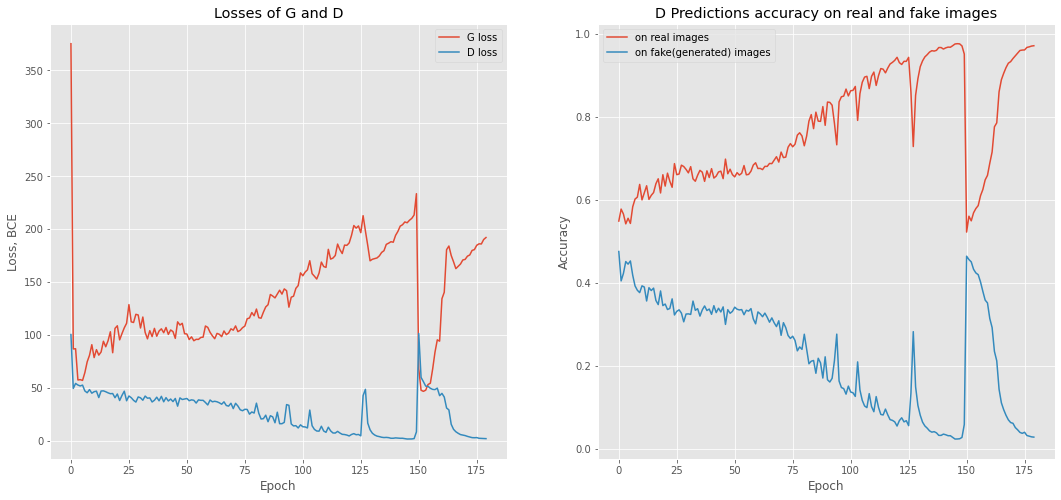

In [43]:
plot_history()

In [ ]:
!zip -r /content/generated/to_download.zip /content/generated

In [67]:
files.download('/content/generated/to_download.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
# Function for cropping and saving generated images
def cropped(original_image_path):
  os.mkdir(f'cropped')
  im = Image.open(original_image_path) 
  cropped_image_size = 64
  batch_size = 64
  frame_width = 2 # width of a frame around each image
  left = 1 # setting starting coordinates
  top = 1 # setting starting coordinates
  right = left + cropped_image_size + frame_width # setting starting coordinates
  bottom = top + cropped_image_size  + frame_width # setting starting coordinates
  index = 1
  for i in range(batch_size):
      if right < im.size[0]:
          img = im.crop((left, top, right, bottom))
          name = 'image-{0:0=4d}.png'.format(index)
          left += cropped_image_size + frame_width
          right += cropped_image_size + frame_width
          top = top
          bottom= bottom
      if right >= im.size[0]:
          left = 1
          top += cropped_image_size + frame_width
          right = left + cropped_image_size + frame_width
          bottom = top + cropped_image_size + frame_width
      index += 1
      img.save(f'cropped/'+ name, 'PNG')

In [56]:
# Cropping and saving some images
cropped('/content/generated/generated-images-0180.png')

In [59]:
# Move your favorite cropped images to this folder
!mkdir '/content/best_arts'

In [60]:
!mv '/content/cropped/image-0001.png' '/content/best_arts'
!mv '/content/cropped/image-0002.png' '/content/best_arts'
!mv '/content/cropped/image-0004.png' '/content/best_arts'
!mv '/content/cropped/image-0007.png' '/content/best_arts'
!mv '/content/cropped/image-0010.png' '/content/best_arts'
!mv '/content/cropped/image-0012.png' '/content/best_arts'
!mv '/content/cropped/image-0017.png' '/content/best_arts'
!mv '/content/cropped/image-0019.png' '/content/best_arts'
!mv '/content/cropped/image-0024.png' '/content/best_arts'
!mv '/content/cropped/image-0031.png' '/content/best_arts'
!mv '/content/cropped/image-0033.png' '/content/best_arts'
!mv '/content/cropped/image-0034.png' '/content/best_arts'
!mv '/content/cropped/image-0038.png' '/content/best_arts'
!mv '/content/cropped/image-0043.png' '/content/best_arts'
!mv '/content/cropped/image-0059.png' '/content/best_arts'
!mv '/content/cropped/image-0062.png' '/content/best_arts'

In [61]:
# Trying ISR for some of them

In [62]:
def RDN_func(image_path):
    rdn = RDN(weights='noise-cancel')

    image = Image.open(image_path)
    display(image)

    first = rdn.predict(np.array(image))
#   first = Image.fromarray(first)

    second = rdn.predict(np.array(first))
#   second = Image.fromarray(second)

    third = rdn.predict(np.array(second))
#   third = Image.fromarray(third)

    display(Image.fromarray(third))
    return image, third

In [ ]:
for file in os.listdir('/content/best_arts'):
    RDN_func('/content/best_arts/' + file)